In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
import pandas as pd

from change_t_0_with_noise_change_utils import psiam_tied_data_gen_wrapper_noise_change_with_T0

# Params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(50e3)
dt = 1e-4

new_noise_step_size = 800
N_print = int(10e3)

N_params = 10
T_0_percentage_change = 5

# ABL, ILD, stim and led times from data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate many

In [4]:
noise_change_results_dict = {}
for i in range(N_params):
    new_noise = 0 + i * new_noise_step_size

    with parallel_backend('threading', n_jobs=-1):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_noise_change_with_T0)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E,\
                                                               t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_noise, T_0_percentage_change,\
                                                                iter_num, N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f' new noise: {new_noise}')

    noise_change_results_dict[i] = {'results': sim_results, 'new_noise':  new_noise , 'T_0_percentage_change': T_0_percentage_change}

os id: 2520479, In iter_num: 0, ABL: 20, ILD: -1.0, t_stim: 1.44555925265872
os id: 2520479, In iter_num: 10000, ABL: 60, ILD: 16.0, t_stim: 1.7761414391676
os id: 2520479, In iter_num: 20000, ABL: 20, ILD: -4.0, t_stim: 0.237879522895848
os id: 2520479, In iter_num: 30000, ABL: 40, ILD: -4.0, t_stim: 0.433978337151527
os id: 2520479, In iter_num: 40000, ABL: 20, ILD: 4.0, t_stim: 0.460769874221833
 new noise: 0
os id: 2520479, In iter_num: 0, ABL: 60, ILD: -2.0, t_stim: 0.409757755188005
os id: 2520479, In iter_num: 10000, ABL: 40, ILD: -4.0, t_stim: 0.483036094107276
os id: 2520479, In iter_num: 20000, ABL: 60, ILD: 2.0, t_stim: 0.572637046411773
os id: 2520479, In iter_num: 30000, ABL: 60, ILD: 2.0, t_stim: 0.261989796248203
os id: 2520479, In iter_num: 40000, ABL: 40, ILD: 1.0, t_stim: 0.765856231358585
 new noise: 800
os id: 2520479, In iter_num: 0, ABL: 20, ILD: 4.0, t_stim: 1.71103450541879
os id: 2520479, In iter_num: 10000, ABL: 60, ILD: 2.0, t_stim: 0.379613215240212
os id: 2

# mean, acc vs param

In [5]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  noise_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  noise_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)



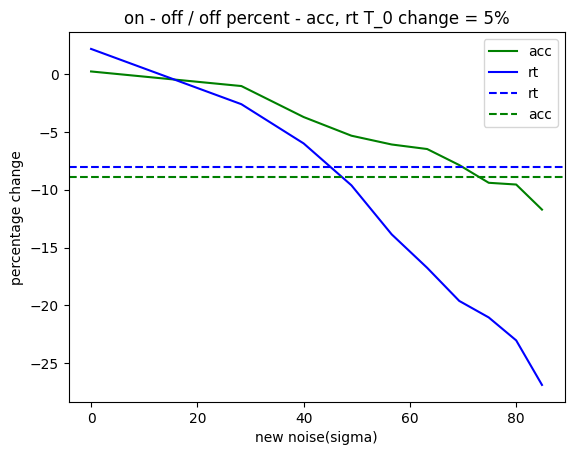

In [6]:
plt.plot([np.sqrt(i * new_noise_step_size) for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='acc', color='g')
plt.plot([np.sqrt(i * new_noise_step_size) for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='rt', color='b')

plt.axhline(-8.0781, label='rt', color='b', linestyle='--')
plt.axhline(-8.9482, label='acc', color='g', linestyle='--')

plt.xlabel('new noise(sigma)')
plt.ylabel('percentage change')
plt.legend()
plt.title(f'on - off / off percent - acc, rt T_0 change = {T_0_percentage_change}%');

# diagnostics

In [14]:
base_noise_data = noise_change_results_dict[0]['results']


# change V_A
new_noise_idx = 9

new_noise_value = noise_change_results_dict[new_noise_idx]['new_noise']
new_noise_data = noise_change_results_dict[new_noise_idx]['results']

# Psycho

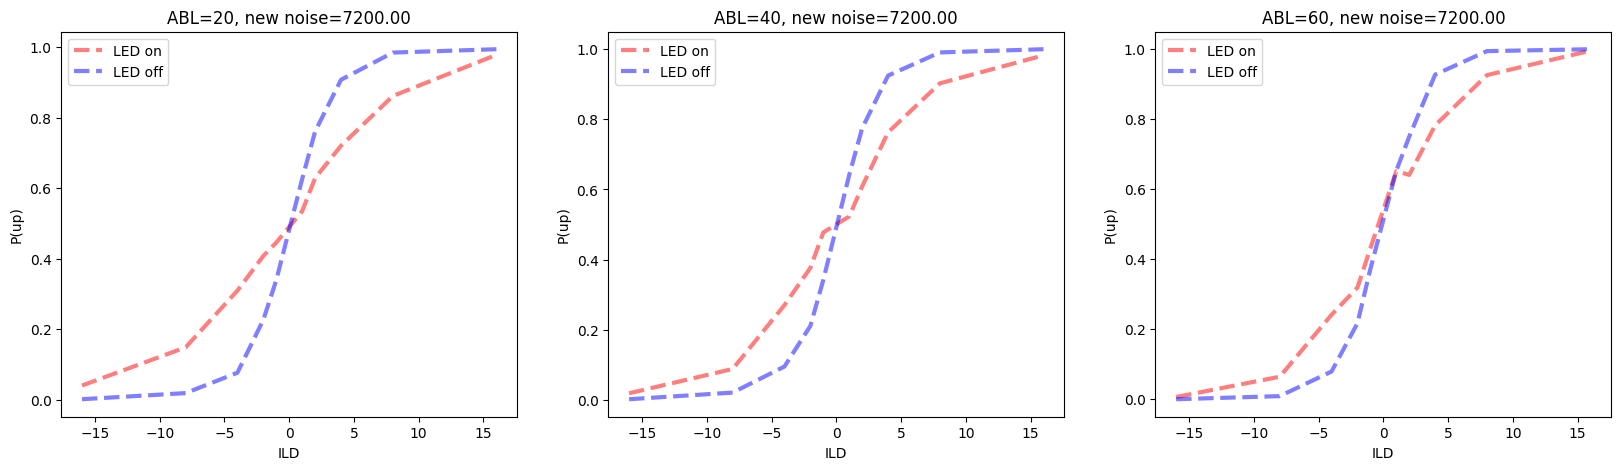

In [15]:
for i in [new_noise_idx]:
    # for each V_A
    each_noise_results = noise_change_results_dict[i]['results']
    new_noise = noise_change_results_dict[i]['new_noise']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_noise_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL}, new noise={new_noise:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');




# percentiles

In [16]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_noise_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_noise_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)



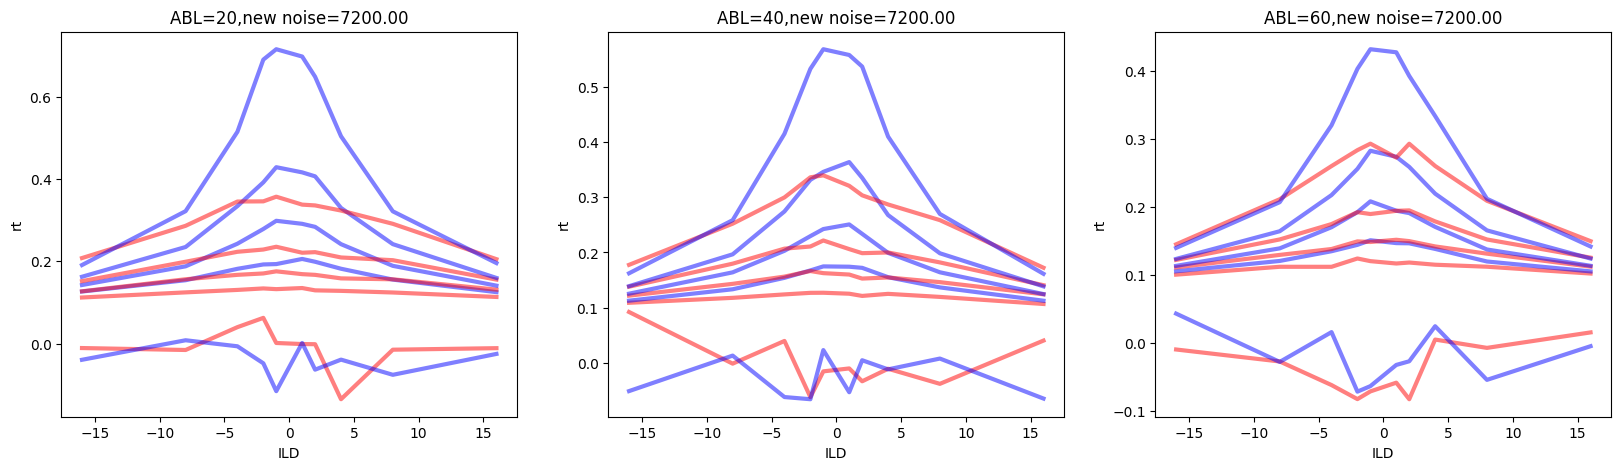

In [17]:


# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},new noise={new_noise_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('rt');

# chronometric

In [18]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

In [19]:
# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

#  base
for res in base_noise_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_noise_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])


# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))

# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

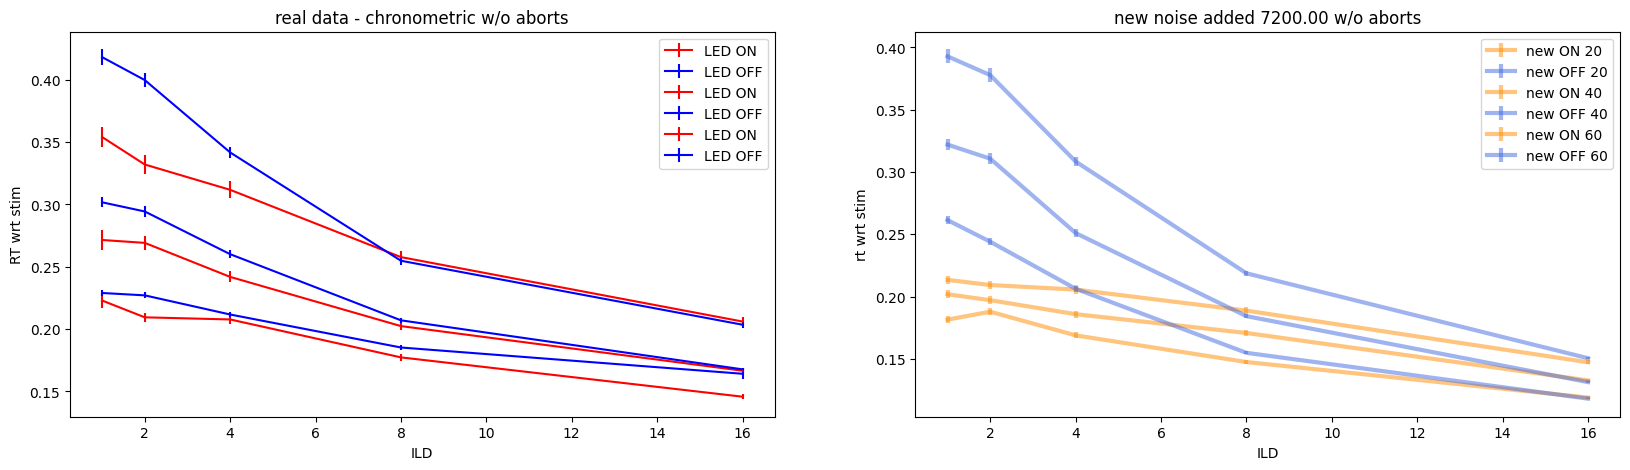

In [20]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')

plt.subplot(1,2,2)
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'new noise added {new_noise_value:.2f} w/o aborts')